In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tslearn
import math
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from tslearn.metrics import dtw, dtw_path
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from scipy.spatial import distance
import numpy as np
from tslearn.metrics import dtw, dtw_path
from tslearn.clustering import TimeSeriesKMeans
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from scipy.cluster.hierarchy import fcluster
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
from matplotlib.dates import DateFormatter
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

     |████████████████████████████████| 793 kB 32.6 MB/s 


/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning:

Scikit-learn <0.24 will be deprecated in a future release of tslearn



# Case Rate Clusters for States and UTs of India

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise.csv")
del df['Status-C']
del df['Status-R']
del df['Status-D']
del df['Status-T']
del df['UN-C']
del df['UN-R']
del df['UN-D']
del df['UN-T']
del df['DD-C']
del df['DD-R']
del df['DD-D']
del df['DD-T']
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
del df['Date']
cols=list(df.columns)
df.tail()


,TT-C,TT-R,TT-D,TT-T,AN-C,AN-R,AN-D,AN-T,AP-C,AP-R,AP-D,AP-T,AR-C,AR-R,AR-D,AR-T,AS-C,AS-R,AS-D,AS-T,BR-C,BR-R,BR-D,BR-T,CH-C,CH-R,CH-D,CH-T,CT-C,CT-R,CT-D,CT-T,DN-C,DN-R,DN-D,DN-T,DL-C,DL-R,DL-D,DL-T,...,PY-C,PY-R,PY-D,PY-T,PB-C,PB-R,PB-D,PB-T,RJ-C,RJ-R,RJ-D,RJ-T,SK-C,SK-R,SK-D,SK-T,TN-C,TN-R,TN-D,TN-T,TG-C,TG-R,TG-D,TG-T,TR-C,TR-R,TR-D,TR-T,UP-C,UP-R,UP-D,UP-T,UT-C,UT-R,UT-D,UT-T,WB-C,WB-R,WB-D,WB-T
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-07,18123,20503,233,0,9,5,0,0,295,368,1,0,4,13,0,0,57,48,2,0,377,423,4,0,43,57,2,0,1010,1253,7,0,0,0,0,0,486,780,19,0,...,35,47,1,0,277,290,10,0,509,735,4,0,14,13,0,0,805,911,12,0,379,305,3,0,8,8,0,0,503,646,10,0,249,439,6,0,921,1295,18,0
2021-01-08,18453,19242,229,0,1,2,0,0,319,308,1,0,7,9,0,0,50,54,0,0,452,504,4,0,54,55,1,0,960,759,15,0,1,0,0,0,444,823,10,0,...,20,36,0,0,299,252,15,0,471,537,0,0,14,86,0,0,790,897,8,0,346,397,2,0,5,9,1,0,767,1001,17,0,269,390,7,0,926,1136,21,0
2021-01-09,18820,19460,213,0,0,7,0,0,199,423,1,0,3,16,0,0,34,56,1,0,493,411,2,0,50,59,1,0,1014,770,15,0,0,1,0,0,519,603,12,0,...,36,51,0,0,248,301,2,0,430,1098,4,0,5,29,0,0,761,882,7,0,298,474,2,0,0,0,0,0,1286,1375,24,0,287,243,6,0,787,978,20,0
2021-01-10,16086,16737,150,0,1,2,0,0,227,289,1,0,5,3,0,0,25,29,1,0,359,408,4,0,44,31,0,0,661,962,6,0,0,2,0,0,399,602,12,0,...,30,40,2,0,299,312,6,0,475,476,3,0,4,22,0,0,724,857,7,0,351,415,2,0,8,10,0,0,275,561,2,0,223,303,5,0,823,957,19,0
2021-01-11,12481,18578,166,0,3,9,0,0,121,213,2,0,5,8,0,0,45,64,3,0,213,378,5,0,47,29,0,0,853,1255,15,0,2,0,0,0,306,407,13,0,...,22,34,0,0,192,265,2,0,429,568,2,0,1,30,0,0,682,869,6,0,224,461,1,0,0,7,0,0,509,770,9,0,156,523,5,0,612,939,16,0


In [ ]:
current_ds=df[list(cols[i] for i in filter(lambda i:i%4==0, range(len(cols))))]
recovered_ds=df[list(cols[i] for i in filter(lambda i:i%4==1, range(len(cols))))]
deceased_ds=df[list(cols[i] for i in filter(lambda i:i%4==2, range(len(cols))))]

### Sunday Anomaly

(array([ 6000.,  8000., 10000., 12000., 14000., 16000., 18000., 20000.,
        22000.]), <a list of 9 Text major ticklabel objects>)

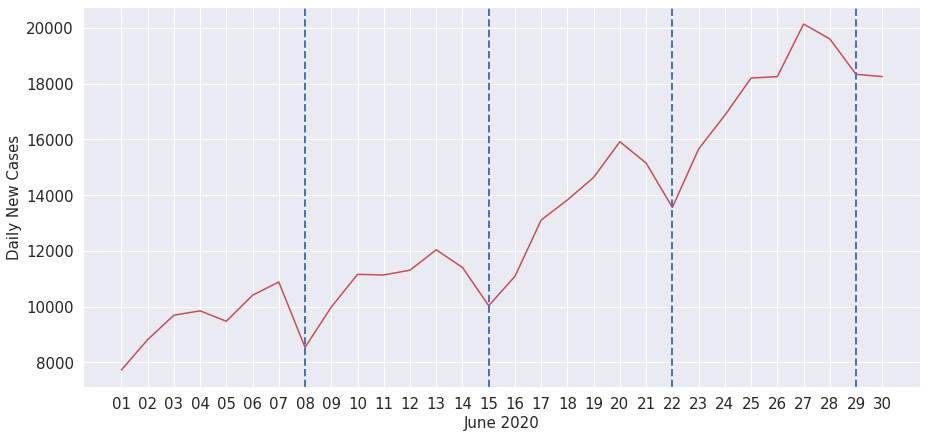

In [ ]:
plt.plot(current_ds.iloc[79:109]['TT-C'],label="India",c='r')
plt.xticks(ticks=current_ds.iloc[79:109]['TT-C'].index,labels=current_ds.iloc[79:109]['MH-C'].index.strftime("%d"))
plt.axvline(pd.to_datetime('2020-06-08') ,color='b', linestyle='--', lw=2)
plt.axvline(pd.to_datetime('2020-06-15') ,color='b', linestyle='--', lw=2)
plt.axvline(pd.to_datetime('2020-06-22') ,color='b', linestyle='--', lw=2)
plt.axvline(pd.to_datetime('2020-06-29') ,color='b', linestyle='--', lw=2)
plt.ylabel("Daily New Cases",fontsize=15)
plt.xlabel("June 2020",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

### Correlation of Population and Cases

In [ ]:
population = {
    "TT": 1210854977,
    "AN": 380581,
    "AP": 49577103,
    "AR": 1383727,
    "AS": 31205576,
    "BR": 104099452,
    "CH": 1055450,
    "CT": 25545198,
    "DN": 585764,
    "DL": 16787941,
    "GA": 1458545,
    "GJ": 60439692,
    "HR": 25351462,
    "HP": 6864602,
    "JK": 12267032,
    "JH": 32988134,
    "KA": 61095297,
    "KL": 33406061,
    "LA": 274000,
    "LD": 64473,
    "MP": 72626809,
    "MH": 112374333,
    "MN": 2570390,
    "ML": 2966889,
    "MZ": 1097206,
    "NL": 1978502,
    "OR": 41974219,
    "PY": 1247953,
    "PB": 27743338,
    "RJ": 68548437,
    "SK": 610577,
    "TN": 72147030,
    "TG": 35003674,
    "TR": 3673917,
    "UP": 199812341,
    "UT": 10086292,
    "WB": 91276115
}
name_to_code = {
    "Andaman and Nicobar Islands":"AN",
    "Andhra Pradesh":"AP",
    "Arunachal Pradesh":"AR",
    "Assam":"AS",
    "Bihar":"BR",
    "Chandigarh":"CH",
    "Chhattisgarh":"CT",
    "Dadra and Nagar Haveli and Daman and Diu":"DN",
    "Delhi":"DL",
    "Goa":"GA",
    "Gujarat":"GJ",
    "Haryana":"HR",
    "Himachal Pradesh":"HP",
    "Jammu and Kashmir":"JK",
    "Jharkhand":"JH",
    "Karnataka":"KA",
    "Kerala":"KL",
    "Ladakh":"LA",
    "Madhya Pradesh":"MP",
    "Maharashtra":"MH",
    "Manipur":"MN",
    "Meghalaya":"ML",
    "Mizoram":"MZ",
    "Nagaland":"NL",
    "Odisha":"OR",
    "Puducherry":"PY",
    "Punjab":"PB",
    "Rajasthan":"RJ",
    "Sikkim":"SK",
    "Tamil Nadu":"TN",
    "Telangana":"TG",
    "Tripura":"TR",
    "Uttar Pradesh":"UP",
    "Uttarakhand":"UT",
    "West Bengal":"WB",
    "Lakshwadeep":"LD",
    "India":"TT"
}
code_to_name = {v: k for k, v in name_to_code.items()}

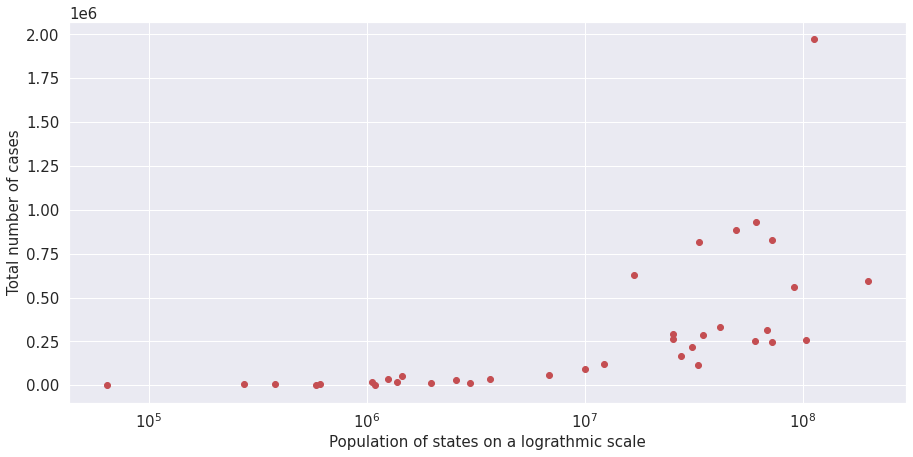

In [ ]:
cases_abs=current_ds.cumsum().tail(1)
population_axis=pd.DataFrame(population,index=population.keys()).head(1)
del population_axis['TT']
del cases_abs['TT-C']
fig = plt.figure()
ax = plt.gca()
ax.scatter(population_axis,cases_abs,c='r')
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.set_ylabel('Total number of cases',fontsize=15)
ax.set_xlabel('Population of states on a lograthmic scale',fontsize=15)
ax.yaxis.get_offset_text().set_fontsize(15)

## Computing the DTW Score Matrix and the dendrogram using Complete Linkage

In [ ]:
def getDTWPath_and_Score(dataset):
  cols=list(dataset.columns)
  pathDs=pd.DataFrame(columns=cols)
  scoreDs=pd.DataFrame(columns=cols)
  pathDs['Names']=[]
  scoreDs['Names']=[]
  # print(scoreDs)
  for i in range(len(cols)):
    path_list=[]
    score_list=[]
    for j in range(len(cols)):
      optimal_path, dtw_score = dtw_path(dataset[cols[i]], dataset[cols[j]], sakoe_chiba_radius=7)  # ADDITIONAL CONSTRAINT
      path_list.append(optimal_path)
      score_list.append(dtw_score)
    path_list.append(cols[i])
    score_list.append(cols[i])
    # print(score_list)
    pathDs.loc[len(pathDs.index)]=path_list
    scoreDs.loc[len(scoreDs.index)]=score_list
    # print(scoreDs)
  return pathDs,scoreDs

In [ ]:
# Normalising the data first
normalised_ds=current_ds.astype(float)
for j in normalised_ds.columns:
  val=population[j[:2]]
  for i in range(len(normalised_ds)):
    normalised_ds.iloc[i][j]/=val
normalised_ds["MH-C"]["2020-12-16"]=5.26276761082088e-05 #Problem with data -ve value

In [ ]:
pathDs,scoreDs=getDTWPath_and_Score(normalised_ds)
scoreDs.index=scoreDs['Names']
scoreDs.drop(labels='Names',axis=1,inplace=True)
scoreDs.index.name=None

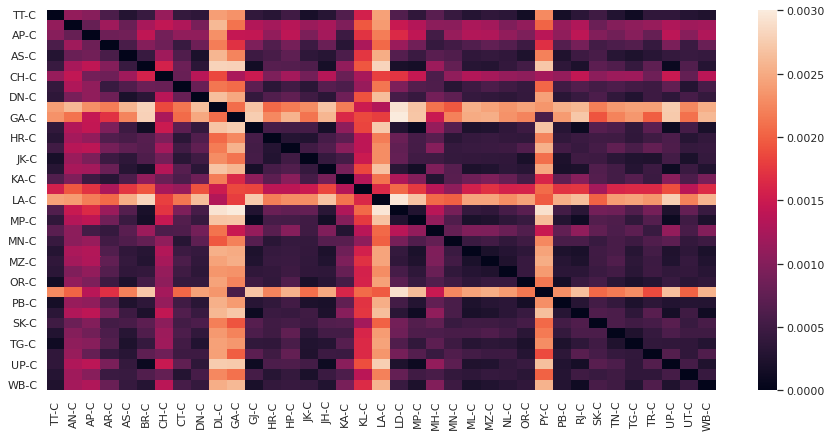

In [ ]:
sns.heatmap(scoreDs)

In [ ]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    fig, ax = plt.subplots()
    fig.canvas.draw()
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()

    return Z,ax.get_xticklabels(),dn

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



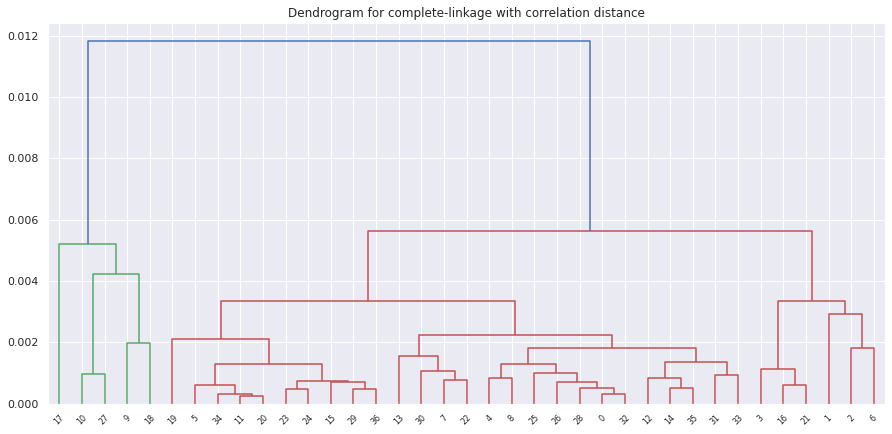

In [ ]:
linkage_matrix,labels,dn = hierarchical_clustering(scoreDs)

In [ ]:
from scipy.cluster import hierarchy
rootnode, nodelist = hierarchy.to_tree(linkage_matrix, rd=True)

In [ ]:
nodelist

In [ ]:
dn['leaves']

[17,
 10,
 27,
 9,
 18,
 19,
 5,
 34,
 11,
 20,
 23,
 24,
 15,
 29,
 36,
 13,
 30,
 7,
 22,
 4,
 8,
 25,
 26,
 28,
 0,
 32,
 12,
 14,
 35,
 31,
 33,
 3,
 16,
 21,
 1,
 2,
 6]

In [ ]:
class Node:
  index=0
  left=None
  right=None
  def __init__(self,idx):
    index=idx

In [ ]:
# def makeTree(dn):
#   '''
#     dn={['icoord','dcoord']}
#   '''
#   # n=len(dn['ivl'])
#   X=dn['icoord']
#   Y=dn['dcoord']

#   # L=dn['ivl']
#   maxIdx=0
#   maxVal=Y[0][0]
#   L=[]
#   for i in range(len(Y)):
#     y=Y[i]
#     for j in range(len(y)):
#       if y[j]>maxVal:
#         maxVal=y[j]
#         maxIdx=i
#       if y[j]==0:
#         L.append(X[i][j])
#   L=sorted(L)

#   root=Node(maxIdx)
#   helper(X,Y,root)
#   def helper(X,Y,root):
#     x=X[root.index] # x1 .... x4
#     y=Y[root.index] # y1 .... y4
#     lIdx=-1
#     rIdx=-1
#     for i in range(len(X)):
#       xx=X[i]
#       yy=Y[i]
#       if xx[1]<x[0] and x[0]<xx[2] and yy[1]==y[0]:
#         lIdx=i
#       if xx[1]<x[3] and x[3]<xx[2] and yy[1]==y[3]:
#         rIdx=i
#       if lIdx!=-1 and rIdx!=-1:
#           break
#     if()





SyntaxError: ignored

In [ ]:
labelsd=[]
for l in labels:
  labelsd.append(int(l.get_text()))

In [ ]:
breakpoints=[18,36,33,6] # Visual Clustering
index=[-1]
for i in range(len(breakpoints)):
  index.append(labelsd.index(breakpoints[i]))
clusters=[]
for i in range(len(index)):
  clusters.append(labelsd[index[i-1]+1:index[i]+1])

In [ ]:
num_to_code={}
for i in range(len(scoreDs.columns)):
  num_to_code[i]=scoreDs.columns[i]

In [ ]:
for i in range(1,5):
  print("*****States in Cluster ",i)
  for c in clusters[i]:
    print(code_to_name[num_to_code[c][:-2]],end = "\n")
  print()
# 1 - Hotspot RED
# 2 - Controlled PURPLE
# 3 - Moderate PINK
# 4 - Severe YELLOW

*****States in Cluster  1
Kerala
Goa
Puducherry
Delhi
Ladakh

*****States in Cluster  2
Lakshwadeep
Bihar
Uttar Pradesh
Gujarat
Madhya Pradesh
Meghalaya
Mizoram
Jharkhand
Rajasthan
West Bengal

*****States in Cluster  3
Himachal Pradesh
Sikkim
Chhattisgarh
Manipur
Assam
Dadra and Nagar Haveli and Daman and Diu
Nagaland
Odisha
Punjab
India
Telangana
Haryana
Jammu and Kashmir
Uttarakhand
Tamil Nadu
Tripura

*****States in Cluster  4
Arunachal Pradesh
Karnataka
Maharashtra
Andaman and Nicobar Islands
Andhra Pradesh
Chandigarh



(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014]),
 <a list of 8 Text major ticklabel objects>)

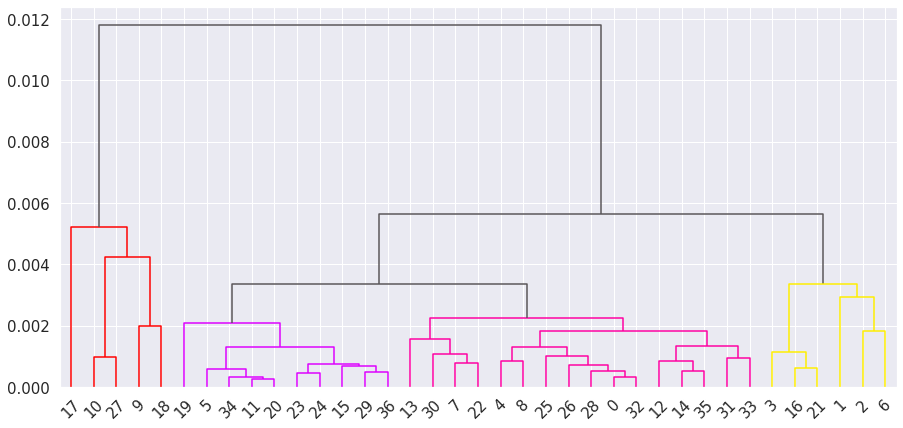

In [ ]:

red="#ff0000"
yellow="#ffee00"
green="#09ff00"
blue="#0011ff"
purple="#dd00ff"
pink="#ff00a2"
dflt_col="#595558"
D_leaf_colors={}
for label in range(len(labelsd)):
  if(label<=labelsd.index(18)):
    D_leaf_colors["attr_"+str(labelsd[label])]=red
  elif(label<=labelsd.index(36)):
    D_leaf_colors["attr_"+str(labelsd[label])]=purple
  elif(label<=labelsd.index(33)):
    D_leaf_colors["attr_"+str(labelsd[label])]=pink
  elif(label<=labelsd.index(6)):
    D_leaf_colors["attr_"+str(labelsd[label])]=yellow
link_cols = {}
for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors["attr_%d"%x] for x in i12)
  link_cols[i+1+len(linkage_matrix)] = c1 if c1 == c2 else dflt_col
D = dendrogram(Z=linkage_matrix, color_threshold=None,
  leaf_font_size=12, leaf_rotation=45, link_color_func=lambda x: link_cols[x])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

### Inter Cluster Plot

(array([-0.0001,  0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005,
         0.0006]), <a list of 8 Text major ticklabel objects>)

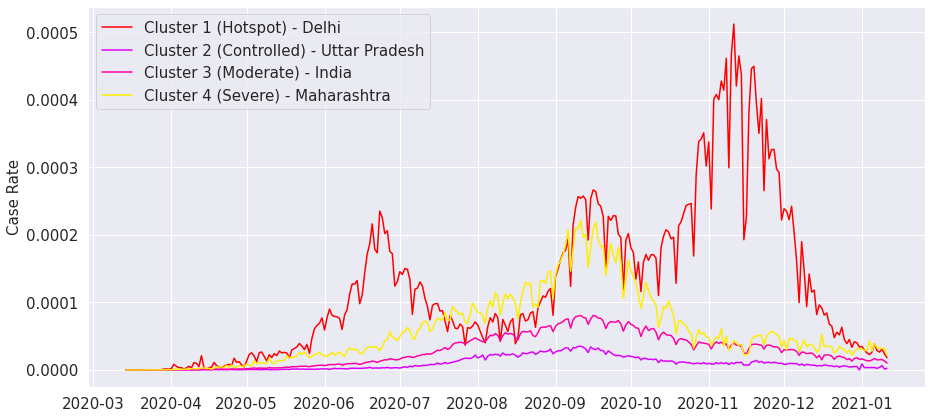

In [ ]:
plt.plot(normalised_ds["DL-C"],label="Cluster 1 (Hotspot) - Delhi",color=red)
plt.plot(normalised_ds["UP-C"],label="Cluster 2 (Controlled) - Uttar Pradesh",color=purple)
plt.plot(normalised_ds["TT-C"],label="Cluster 3 (Moderate) - India",color=pink)
plt.plot(normalised_ds["MH-C"],label="Cluster 4 (Severe) - Maharashtra",color=yellow)
plt.ylabel("Case Rate",fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

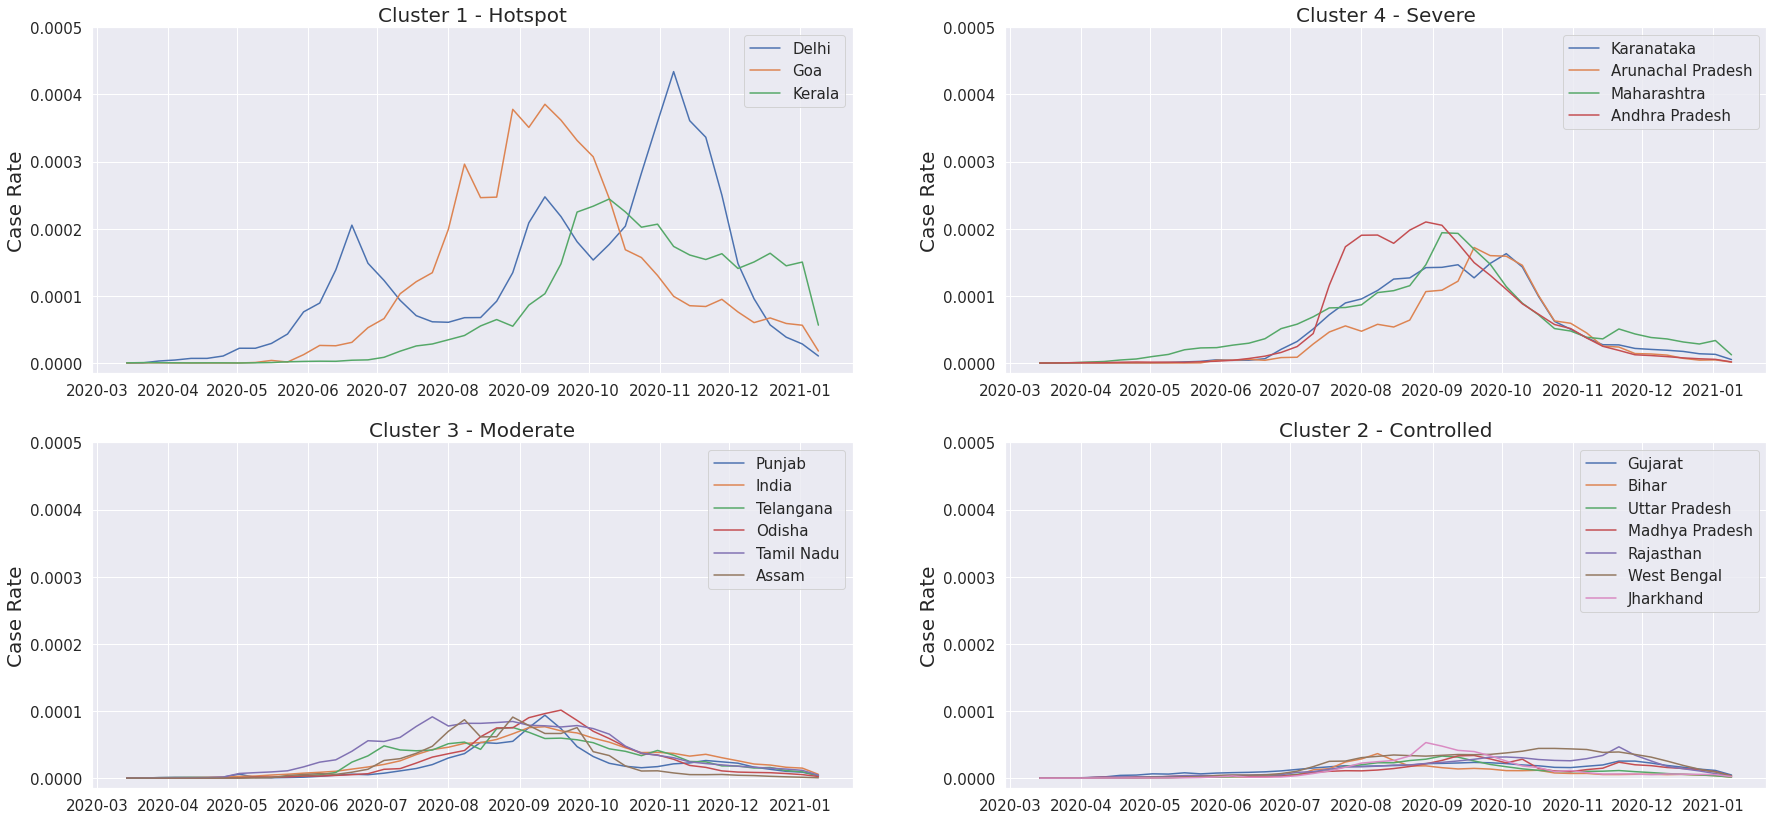

In [ ]:
plt.rcParams["figure.figsize"] = (30,14)
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(normalised_ds["DL-C"].resample('7D').sum()/7,label="Delhi")
axs[0, 0].plot(normalised_ds["GA-C"].resample('7D').sum()/7,label="Goa")
axs[0, 0].plot(normalised_ds["KL-C"].resample('7D').sum()/7,label="Kerala")
axs[0, 0].set_ylim((-0.000015189176564296957, 0.0005))
axs[0, 0].legend(fontsize=15)
axs[0, 0].set_title('Cluster 1 - Hotspot',fontsize=20)


axs[1, 1].plot(normalised_ds["GJ-C"].resample('7D').sum()/7,label="Gujarat")
axs[1, 1].plot(normalised_ds["BR-C"].resample('7D').sum()/7,label="Bihar")
axs[1, 1].plot(normalised_ds["UP-C"].resample('7D').sum()/7,label="Uttar Pradesh")
axs[1, 1].plot(normalised_ds["MP-C"].resample('7D').sum()/7,label="Madhya Pradesh")
axs[1, 1].plot(normalised_ds["RJ-C"].resample('7D').sum()/7,label="Rajasthan")
axs[1, 1].plot(normalised_ds["WB-C"].resample('7D').sum()/7,label="West Bengal")
axs[1, 1].plot(normalised_ds["JH-C"].resample('7D').sum()/7,label="Jharkhand")
axs[1, 1].legend(fontsize=15)
axs[1, 1].set_ylim((-0.000015189176564296957, 0.0005))
axs[1, 1].set_title('Cluster 2 - Controlled',fontsize=20)

axs[1, 0].plot(normalised_ds["PB-C"].resample('7D').sum()/7,label="Punjab")
axs[1, 0].plot(normalised_ds["TT-C"].resample('7D').sum()/7,label="India")
axs[1, 0].plot(normalised_ds["TG-C"].resample('7D').sum()/7,label="Telangana")
axs[1, 0].plot(normalised_ds["OR-C"].resample('7D').sum()/7,label="Odisha")
axs[1, 0].plot(normalised_ds["TN-C"].resample('7D').sum()/7,label="Tamil Nadu")
axs[1, 0].plot(normalised_ds["AS-C"].resample('7D').sum()/7,label="Assam")
axs[1, 0].legend(fontsize=15)
axs[1, 0].set_ylim((-0.000015189176564296957, 0.0005))
axs[1, 0].set_title('Cluster 3 - Moderate',fontsize=20)

axs[0, 1].plot(normalised_ds["KA-C"].resample('7D').sum()/7,label="Karanataka")
axs[0, 1].plot(normalised_ds["AR-C"].resample('7D').sum()/7,label="Arunachal Pradesh")
axs[0, 1].plot(normalised_ds["MH-C"].resample('7D').sum()/7,label="Maharashtra")
axs[0, 1].plot(normalised_ds["AP-C"].resample('7D').sum()/7,label="Andhra Pradesh")
axs[0, 1].legend(fontsize=15)
axs[0, 1].set_ylim((-0.000015189176564296957, 0.0005))
axs[0, 1].set_title('Cluster 4 - Severe',fontsize=20)


for ax in axs.flat:
    ax.set_ylabel('Case Rate',fontsize=20)
    ax.tick_params(labelsize=15)

### Validating the number of clusters using Kmeans

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 37 1-dimensional timeseries



Text(0, 0.5, 'Residual Sum of Squares (RSS)')

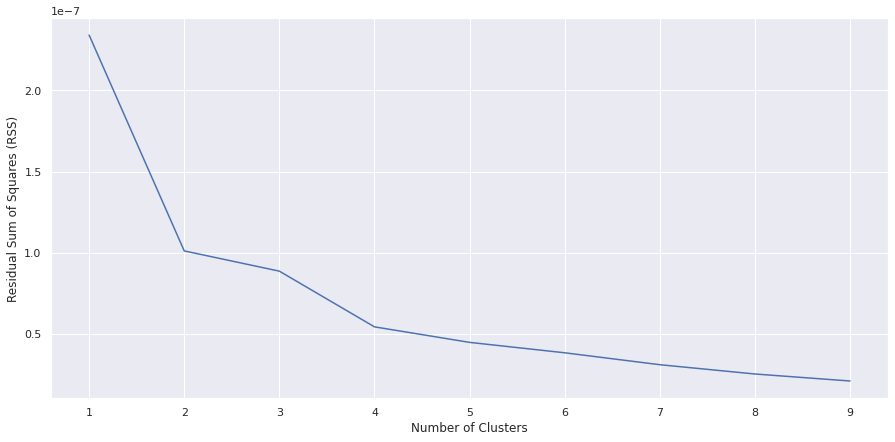

In [ ]:
plt.rcParams["figure.figsize"] = (15,7)
km_dba = TimeSeriesKMeans(n_clusters=4, metric="dtw").fit(normalised_ds.transpose())
km_dba.predict(normalised_ds.transpose())
rss=[]
for k in range(1,10):
  km_dba = TimeSeriesKMeans(n_clusters=k, metric="dtw").fit(normalised_ds.transpose())
  rss.append(km_dba.inertia_)
rss_temp=[]
for rr in rss:
  rss_temp.append(rr)
xax=[1,2,3,4,5,6,7,8,9]
plt.plot(xax,rss)
plt.xlabel("Number of Clusters")
plt.ylabel("Residual Sum of Squares (RSS)")

In [ ]:
for i in range(5,7):
  ff=i/10
  rss=rss_temp.copy()
  for r in range(len(rss)):
    rss[r]=rss_temp[r]+ (ff * 10**(-7))*math.log((r+1))
  xax=[1,2,3,4,5,6,7,8,9]
  plt.plot(xax,rss,label="α = "+str(ff)+"e-7")
  plt.xlabel("Number of Clusters (k)",fontsize=15)
  plt.ylabel("Cost",fontsize=15)
  rss=rss_temp.copy()
  plt.legend(fontsize=15)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.gca().yaxis.get_offset_text().set_fontsize(15)

# *Mortality Rate Analysis for States*

In [ ]:
# Normalising the data first
normalised_ds_deceased=deceased_ds.astype(float)
for j in normalised_ds_deceased.columns:
  val=population[j[:2]]
  for i in range(len(normalised_ds_deceased)):
    normalised_ds_deceased.iloc[i][j]/=val

In [ ]:
pathDs_deceased,scoreDs_deceased=getDTWPath_and_Score(normalised_ds_deceased)
scoreDs_deceased.index=scoreDs_deceased['Names']
scoreDs_deceased.drop(labels='Names',axis=1,inplace=True)
scoreDs_deceased.index.name=None

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



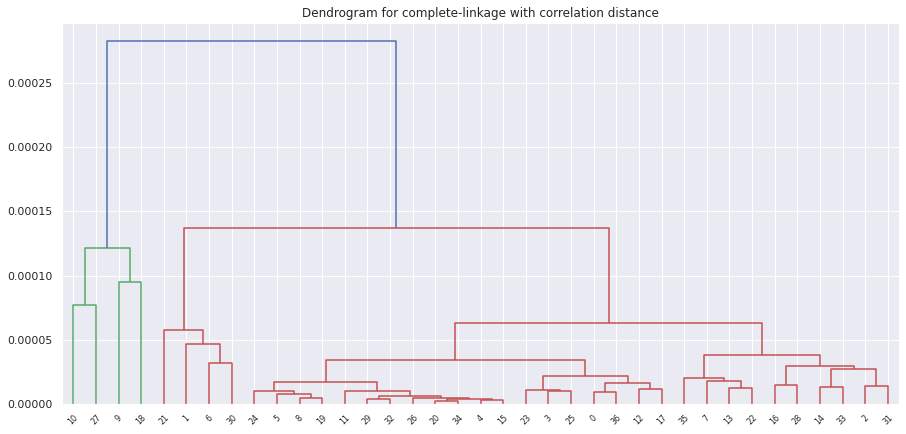

In [ ]:
linkage_matrix,labels = hierarchical_clustering(scoreDs_deceased)

In [ ]:
labelsd=[]
for l in labels:
  labelsd.append(int(l.get_text()))

In [ ]:
breakpoints_deceased=[18,30,17,31] # Visual Clustering
index=[-1]
for i in range(len(breakpoints_deceased)):
  index.append(labelsd.index(breakpoints_deceased[i]))
clusters_deceased=[]
for i in range(len(index)):
  clusters_deceased.append(labelsd[index[i-1]+1:index[i]+1])

In [ ]:
for i in range(1,5):
  print("*****States in Cluster ",i)
  for c in clusters_deceased[i]:
    print(code_to_name[num_to_code[c][:-2]],end = "\n")
  print()

*****States in Cluster  1
Goa
Puducherry
Delhi
Ladakh

*****States in Cluster  2
Maharashtra
Andaman and Nicobar Islands
Chandigarh
Sikkim

*****States in Cluster  3
Mizoram
Bihar
Dadra and Nagar Haveli and Daman and Diu
Lakshwadeep
Gujarat
Rajasthan
Telangana
Odisha
Madhya Pradesh
Uttar Pradesh
Assam
Jharkhand
Meghalaya
Arunachal Pradesh
Nagaland
India
West Bengal
Haryana
Kerala

*****States in Cluster  4
Uttarakhand
Chhattisgarh
Himachal Pradesh
Manipur
Karnataka
Punjab
Jammu and Kashmir
Tripura
Andhra Pradesh
Tamil Nadu



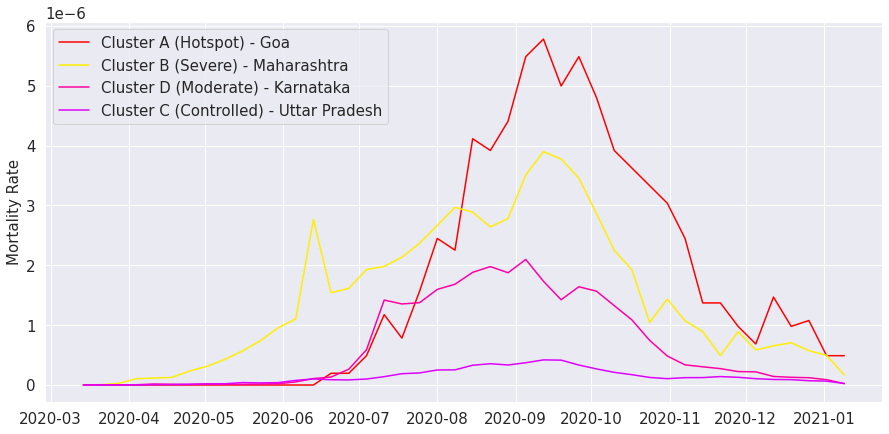

In [ ]:
plt.plot(normalised_ds_deceased['GA-D'].resample('7D').sum()/7,label="Cluster A (Hotspot) - Goa",c='#ff0000')
plt.plot(normalised_ds_deceased['MH-D'].resample('7D').sum()/7,label="Cluster B (Severe) - Maharashtra",c='#ffee00')
plt.plot(normalised_ds_deceased['KA-D'].resample('7D').sum()/7,label="Cluster D (Moderate) - Karnataka",c="#ff00a2")
plt.plot(normalised_ds_deceased['UP-D'].resample('7D').sum()/7,label="Cluster C (Controlled) - Uttar Pradesh",c="#dd00ff")
plt.legend(fontsize=15)
plt.ylabel("Mortality Rate",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().yaxis.get_offset_text().set_fontsize(15)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 37 1-dimensional timeseries



Text(0, 0.5, 'Residual Sum of Squares (RSS)')

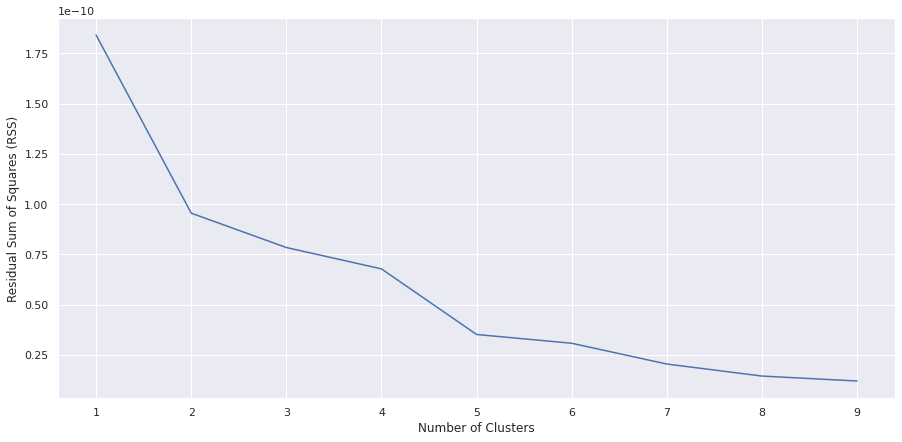

In [ ]:
km_dba = TimeSeriesKMeans(n_clusters=4, metric="dtw").fit(normalised_ds_deceased.transpose())
km_dba.predict(normalised_ds_deceased.transpose())
rss=[]
for k in range(1,10):
  km_dba = TimeSeriesKMeans(n_clusters=k, metric="dtw").fit(normalised_ds_deceased.transpose())
  rss.append(km_dba.inertia_)
rss_temp=[]
for rr in rss:
  rss_temp.append(rr)
xax=[1,2,3,4,5,6,7,8,9]
plt.plot(xax,rss)
plt.xlabel("Number of Clusters")
plt.ylabel("Residual Sum of Squares (RSS)")